# GreenBuildings 2: Imputing Missing Values With Scikit-Learn
------


## Introduction <a class="anchor" id="first-bullet"></a>
-------------
	
This is the second post in a series of blog posts about building a predictive model of green house gas emissions of buildings in NYC. In my first post I covered how to do

- Exploratory data analysis
- Identify and remove outliers

In this current blog post I will cover the very important topic of 

- Imputing missing values

Specifically I will cover [imputations techniques](https://en.wikipedia.org/wiki/Imputation_(statistics)#Regression) using Scikit-Learn's [impute module](https://scikit-learn.org/stable/modules/impute.html) using both point estimates (i.e. mean, median) using the **[SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)** as well as more complicated regression models (i.e. KNN) using the **[IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)**. The later requires that the features in the model are correlated.  This is indeed the case for our dataset and our particular case also involved [transforming](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) the feautres in order to discern a more meaningful and predictive relationship between them. As we will this transformation of the features gives us much better results when it comes to imputing missing values.

I should remark that the choice to impute values introduces bias into our dataset and one must determine if the values to impute are missing at random or missing not at random. Values that are missing not at random are dangerous to impute. See [here](https://en.wikipedia.org/wiki/Missing_data#Missing_completely_at_random) for more information. In this case we don't really know why the data is missing and will impute the missing values regardless.  

In the previous post I talked about using [Google Cloud Platform](https://cloud.google.com/) and won't go over the details of the configuations, but declare them in my list of import below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')

from google.oauth2 import service_account
from google.cloud import bigquery
import json
import pandas_gbq 

credentials = service_account.Credentials\
                             .from_service_account_file('./derby.json')

client = bigquery.Client(project     = credentials.project_id,
                         credentials = credentials)

pandas_gbq.context.credentials = credentials
pandas_gbq.context.project     = credentials.project_id

## Analyzing Distributions & Correlations

Now lets focus our energy on imputing missing values in our dataset. Let's first get the names of the columns 

In [ ]:
result = client.query("""
SELECT 
    column_name
FROM 
    db_gb.INFORMATION_SCHEMA.COLUMNS
WHERE 
    table_name = 'no_outlier_data'
""")

for row in result.result():
    print(row[0])

Now that I know the names of the columns see exactly what number of each column has null values and graph.  To make it more interesting I break this down even further by incorporating where the building was MultiFamily or Office space:

Downloading: 100%|██████████| 2/2 [00:00<00:00, 16.27rows/s]


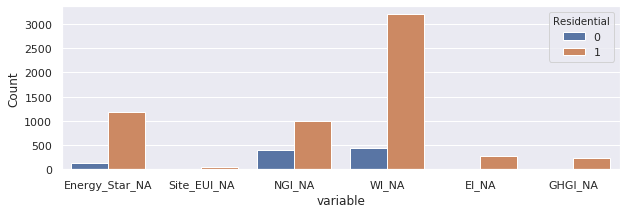

In [30]:
query = """
SELECT
   Residential,
   SUM(CASE WHEN Energy_Star IS NULL THEN 1 ELSE 0 END)  AS Energy_Star_NA,
   SUM(CASE WHEN Site_EUI IS NULL THEN 1 ELSE 0 END)  AS Site_EUI_NA,
   SUM(CASE WHEN NGI IS NULL THEN 1 ELSE 0 END)  AS NGI_NA,
   SUM(CASE WHEN WI IS NULL THEN 1 ELSE 0 END)  AS WI_NA,
   SUM(CASE WHEN EI IS NULL THEN 1 ELSE 0 END)  AS EI_NA,
   SUM(CASE WHEN GHGI IS NULL THEN 1 ELSE 0 END) AS GHGI_NA,
FROM db_gb.raw_data 
GROUP BY Residential
"""

num_nulls_df  = pandas_gbq.read_gbq(query)
num_nulls_df2 = num_nulls_df.melt(id_vars='Residential')\
                            .rename(columns={"value":"Count"})

plt.figure(figsize=(10,3))
sns.barplot(data=num_nulls_df2,
            x='variable',
            y='Count',
            hue='Residential')


However, this isn't quite a fair comparison as we need to account for the percentage of missing values instead of raw numbers:

Downloading: 100%|██████████| 2/2 [00:00<00:00, 17.55rows/s]


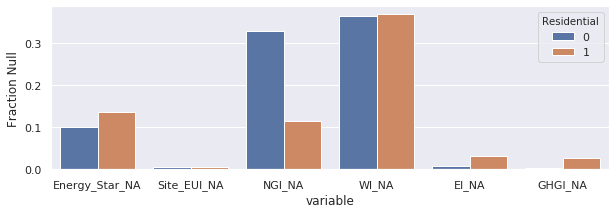

In [31]:
query = """
SELECT
   Residential,
   SUM(CASE WHEN Energy_Star IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS Energy_Star_NA,
   SUM(CASE WHEN Site_EUI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS Site_EUI_NA,
   SUM(CASE WHEN NGI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS NGI_NA,
   SUM(CASE WHEN WI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS WI_NA,
   SUM(CASE WHEN EI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS EI_NA,
   SUM(CASE WHEN GHGI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS GHGI_NA,
FROM 
    db_gb.no_outlier_data 
GROUP BY 
    Residential
"""

frac_nulls_df = pandas_gbq.read_gbq(query)

# reshape the dataframe 
frac_nulls_df2 = frac_nulls_df.melt(id_vars='Residential')\
                              .rename(columns={"value":"Fraction Null"})

plt.figure(figsize=(10,3))
sns.barplot(data=frac_nulls_df2,
            x='variable',
            y='Fraction Null',
            hue='Residential')

Note that we are using the data *without any outliers*, that is the end resuling table of the last [post](). We can see that,

- Water intensity (WI) is the field with highest percentage of missing values

- Natural Gas Intensity (NGI) has the second highest percentage of missing values. 

- Energy Star also has a sizable amount of missing values.

Site Energy Use Intensity (EUI), Electricity Intensity (EI) and Green House Gas (GHGI) have negligable amounts of missing values and those records will be dropped.  The sizable difference between Residential values means we have to take building type into account when imputing these values. 

Let's pull all the columns to determine the relationship of each feature not only with GHGI, but also with all the other features.  We determine the relationships using a heat map of the correlation matrix as we did in the last post:

In [8]:
df = pandas_gbq.read_gbq("""
SELECT
   Energy_Star,
   Site_EUI,
   NGI,
   EI,
   WI,
   GHGI,
   Age,
   OPSFT,
   Residential,
FROM
    db_gb.no_outlier_data
""")

Downloading: 100%|██████████| 9834/9834 [00:00<00:00, 12427.63rows/s]


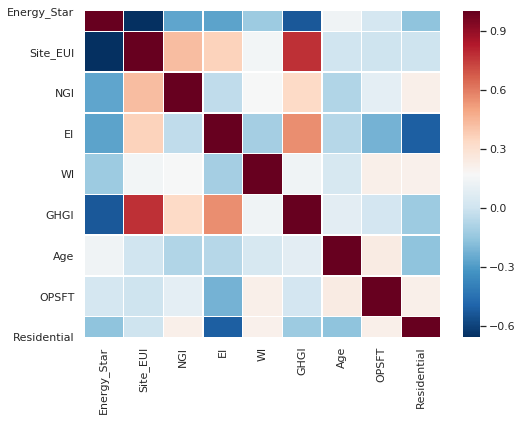

In [82]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
Xs      = scaler1.fit_transform(df)
xs_df   = pd.DataFrame(Xs, columns=df.columns)

fig, ax = plt.subplots(figsize=(8,6))  
sns.color_palette("BuGn_r",)
sns.heatmap(xs_df.corr(),
            linewidths=.5,
            cmap="RdBu_r")

We can see that,

- Occupancy Per Square Foot (OPSFT) and Age are not very correlated with GHGI.  Therefore we will not concern ourselves with them in our model.

- Water intensity is not very correlated and has many missing values

- EI, NGI, Energy_Star, GHGI, and Energy_Star are all highly correlated.

Let's look at the scatter plots of features and GHGI:

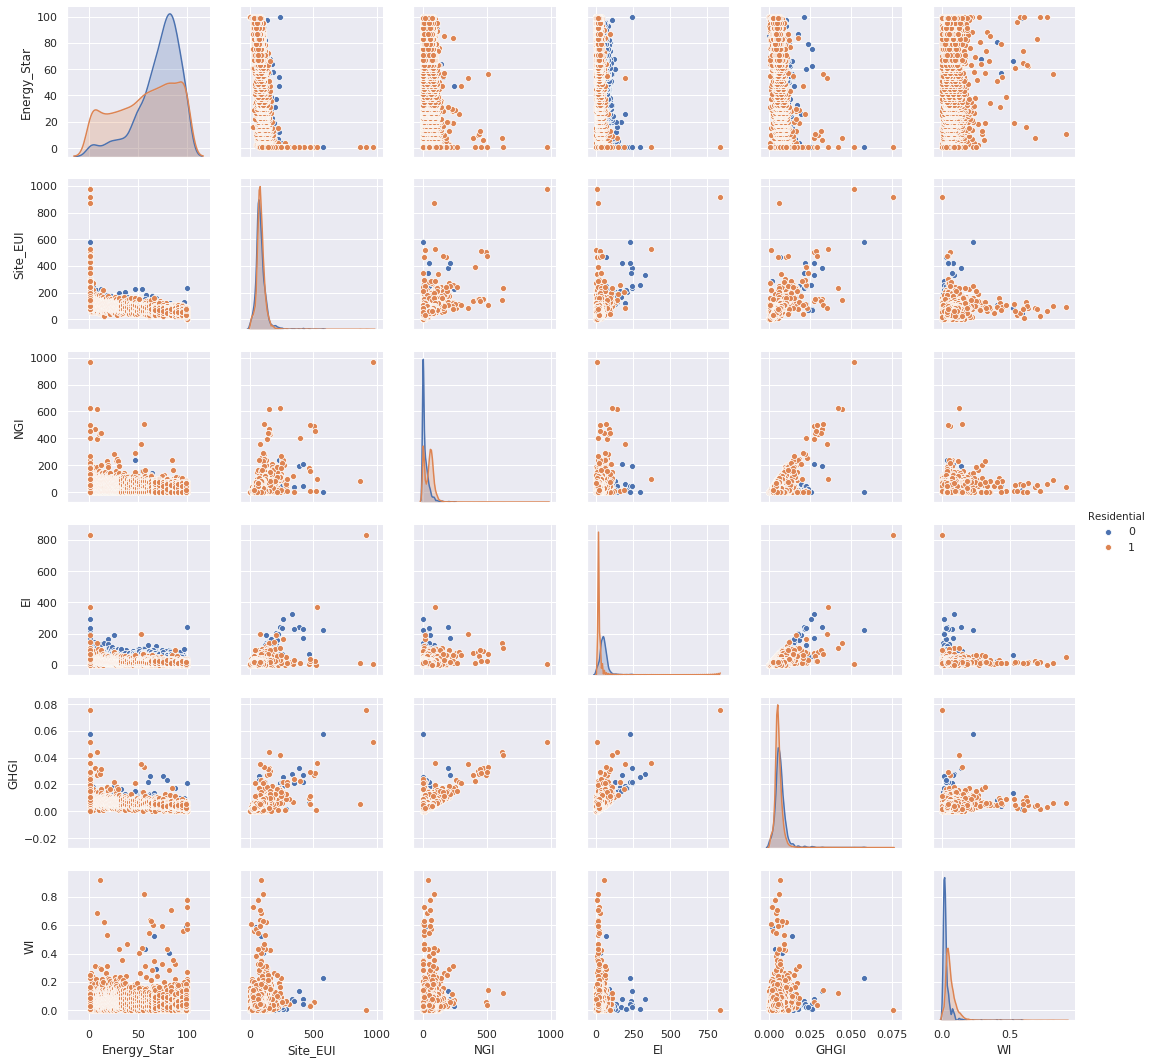

In [23]:
sns.pairplot(df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI", "WI"],
             hue='Residential')

In the above graph the off-diagonal grids are the relationship between the variables while the  graphs along the diagonal are the density of the variables.  We can see from the off-diagonal graphs there is [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) between the features and GHGI, however, we won't address this issue too much in this post. The right most column shows that WI is not correlated with GHGI or any of the other features.  **We therefore will not be imputing missing values for water intensity (WI) and drop it as a feature for the model of GHGI** and instead be focusing on imputing missing values for 

1. **Energy_Star**
2. **NGI**


From the graphs along the diagonal all variables except for Energy_Star have sharply peaked [modes](https://en.wikipedia.org/wiki/Mode_(statistics)) with [long tails](https://en.wikipedia.org/wiki/Long_tail). Interestingly, NGI and EI seem to be bimodal distributions which will make things more difficult. In order to make the relations between features more visible I tried tranforming the data. The first transformation I used was too use the square root of all the variables:

Downloading: 100%|██████████| 9834/9834 [00:01<00:00, 8946.75rows/s]


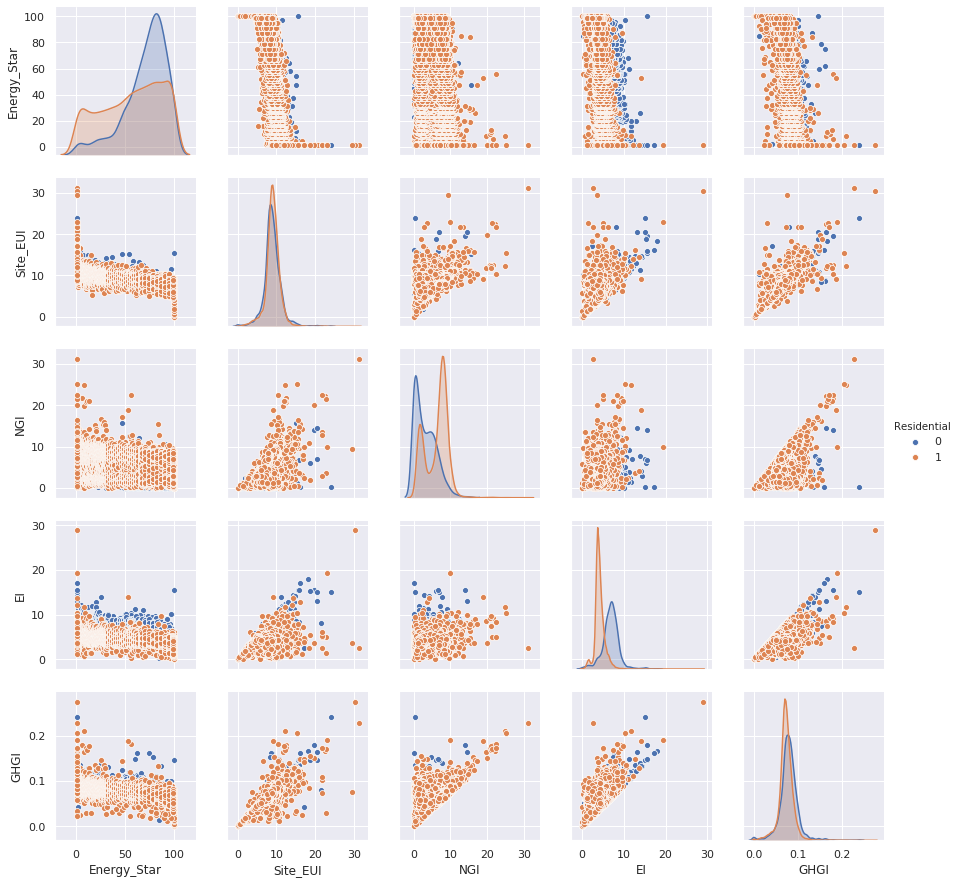

In [3]:
df_sqrt = pandas_gbq.read_gbq("""
SELECT
   Energy_Star,
   SQRT(Site_EUI) AS Site_EUI,
   SQRT(NGI)      AS NGI,
   SQRT(EI)       AS EI,
   SQRT(GHGI)     AS GHGI,
   Residential,
FROM db_gb.no_outlier_data """)

sns.pairplot(df_sqrt,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             hue='Residential')

We can see that neither Energy_Star nor NGI are normally distributed, meaning that a linear regression model would not be appropriate in this situation.  Interesting the relationship between Energy_Star and Site_EUI seams to be [sigmodal](https://en.wikipedia.org/wiki/Sigmoid_function) in shape signfiying a non-linear relationship. The relationship between NGI and Site_EUI and GHGI seems to be linear, but suffering from [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity). One way to reduce the variance is to use transform square root of NGI by taking the log of it. Inorder to avoid the issue of introducing infinities into our dataset we add a 1 when transforming it:

In [4]:
df_sqrt["LOG_NGI"] = np.log(1+df_sqrt["NGI"])

Now lets look at the relationship of this with respect to the square root of the features:

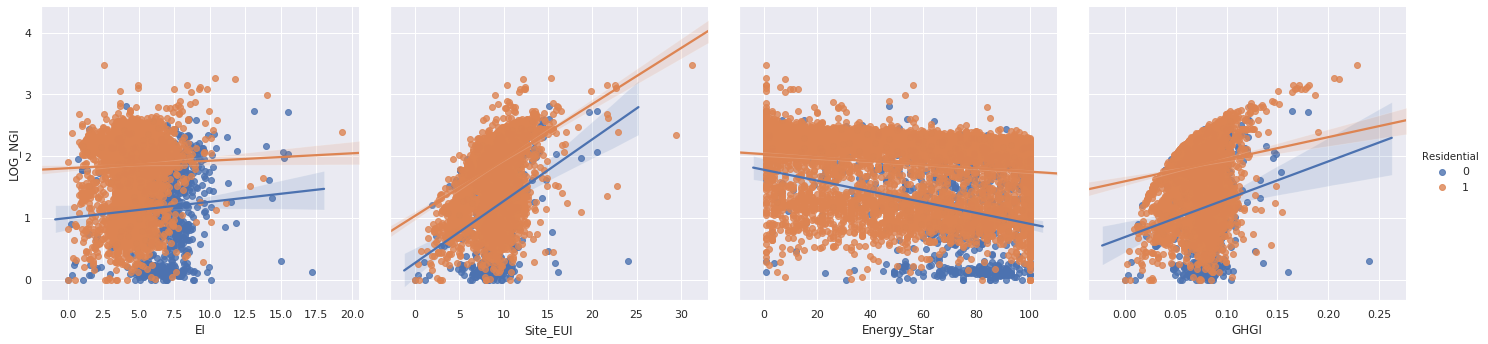

In [11]:
sns.pairplot(df_sqrt, 
             x_vars=['EI','Site_EUI','Energy_Star','GHGI'], 
             y_vars='LOG_NGI', 
             hue='Residential',
             kind = 'reg',
             size=5, 
             dropna=True)

We can see that that the heteroscedasticity between LOG_NGI and Site_EUI has been reduced.  Let's look at what this transofmration

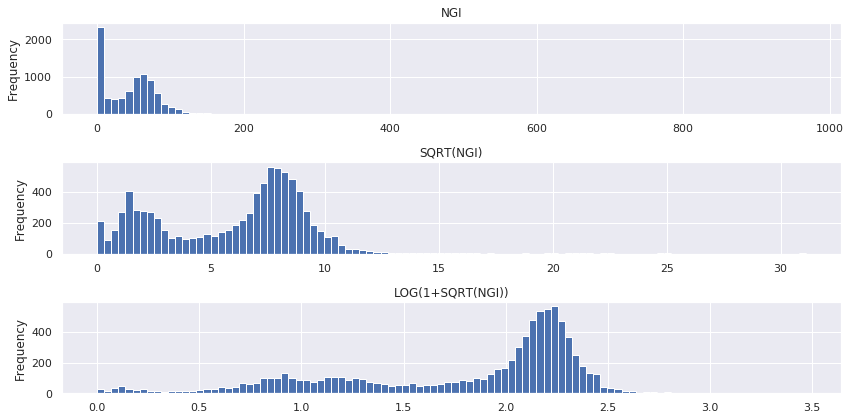

In [32]:
plt.figure(figsize=(12,6))
plt.subplot(311)
df["NGI"].plot(kind="hist",bins=100,title="NGI")

plt.subplot(312)
df_sqrt["NGI"].plot(kind="hist",bins=100,title="SQRT(NGI)")

plt.subplot(313)
df_sqrt["LOG_NGI"].plot(kind="hist",bins=100,title="LOG(1+SQRT(NGI))")

plt.tight_layout()

## Imputing Missing Values With Scikit-Learn

In [88]:
df2 = pandas_gbq.read_gbq("""
SELECT
   Energy_Star AS    Energy_Star,
   SQRT(Site_EUI)    AS Site_EUI,
--   SQRT(NGI)         AS NGI,
   LOG(1 + SQRT(NGI)) AS LOG_NGI,
   SQRT(EI)          AS EI,
   SQRT(GHGI)        AS GHGI,
   Residential,
FROM 
    db_gb.no_outlier_data
WHERE 
    GHGI IS NOT NULL
AND EI IS NOT NULL
AND Site_EUI IS NOT NULL
""")

Downloading: 100%|██████████| 9542/9542 [00:01<00:00, 7945.98rows/s]


In [76]:
df2.shape[0]

9542

In [89]:
from sklearn.model_selection import train_test_split, cross_val_score

X_real = df2.drop(['GHGI'], axis=1)
Y_real = df2['GHGI']

X_train, X_test, Y_train, Y_test = train_test_split(X_real,Y_real, random_state=32)

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline     import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute       import SimpleImputer, IterativeImputer
from sklearn.neighbors    import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import r2_score

In [91]:
median_pipe = make_pipeline(SimpleImputer(strategy='median'),
                            StandardScaler(),
                            LinearRegression())
 
np.mean(cross_val_score(median_pipe, X_train, Y_train, cv=5))

0.7753357218431123

In [92]:
median_pipe.fit(X_train, Y_train)
Y_pred = median_pipe.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(Y_test, Y_pred)))

Variance score: 0.7397380693145259


In [93]:
mean_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                          StandardScaler(),
                          LinearRegression())

np.mean(cross_val_score(mean_pipe, X_train, Y_train, cv=5))

0.7782249273195783

In [94]:
mean_pipe.fit(X_train, Y_train)
Y_pred = mean_pipe.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(Y_test, Y_pred)))

Variance score: 0.7423399799230215


In [95]:
knn_pipe = Pipeline([("scaler",  StandardScaler()),
                     ("imputer", IterativeImputer(estimator=KNeighborsRegressor())),
                     ("reg",     LinearRegression())])

In [96]:
params = {"imputer__estimator__n_neighbors": [1,5,10,15,20],
          "imputer__estimator__weights":     ["uniform","distance"]}

grid   = GridSearchCV(estimator   = knn_pipe,
                      param_grid  = params,
                      scoring     = "r2",
                      cv          = 5,
                      n_jobs      =-1)

In [97]:
grid.fit(X_train, Y_train)
knn_imputer = grid.best_estimator_

In [98]:
grid.best_score_

0.7790102250391978

In [99]:
Y_pred = knn_imputer.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(Y_test, Y_pred)))

Variance score: 0.7437197904635404


In [100]:
transformer = knn_imputer[0]
transformer 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [101]:
imputer = knn_imputer[1]
imputer

IterativeImputer(add_indicator=False,
                 estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                               metric='minkowski',
                                               metric_params=None, n_jobs=None,
                                               n_neighbors=5, p=2,
                                               weights='uniform'),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=None,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)

In [102]:
X_fixed = transformer.inverse_transform(
                imputer.transform(
                    transformer.transform(X_real)))

In [103]:
X_df = pd.DataFrame(X_fixed, columns=X_real.columns)

In [105]:
X_sqrt_df = pd.concat([X_df.reset_index().drop("index",axis=1), 
                       Y_real.to_frame().reset_index().drop("index",axis=1)], 
                     axis=1)

In [107]:
X_sqrt_df["NGI"] = np.exp(X_sqrt_df["LOG_NGI"])-1

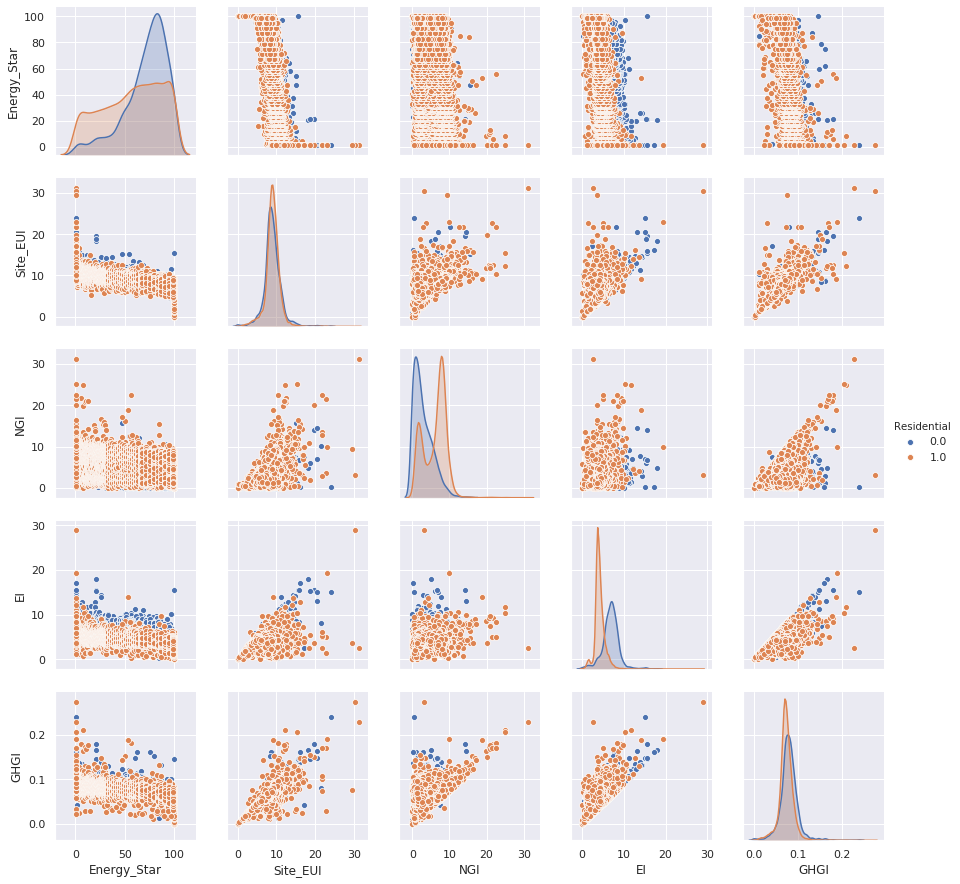

In [108]:
sns.pairplot(X_sqrt_df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             hue='Residential')

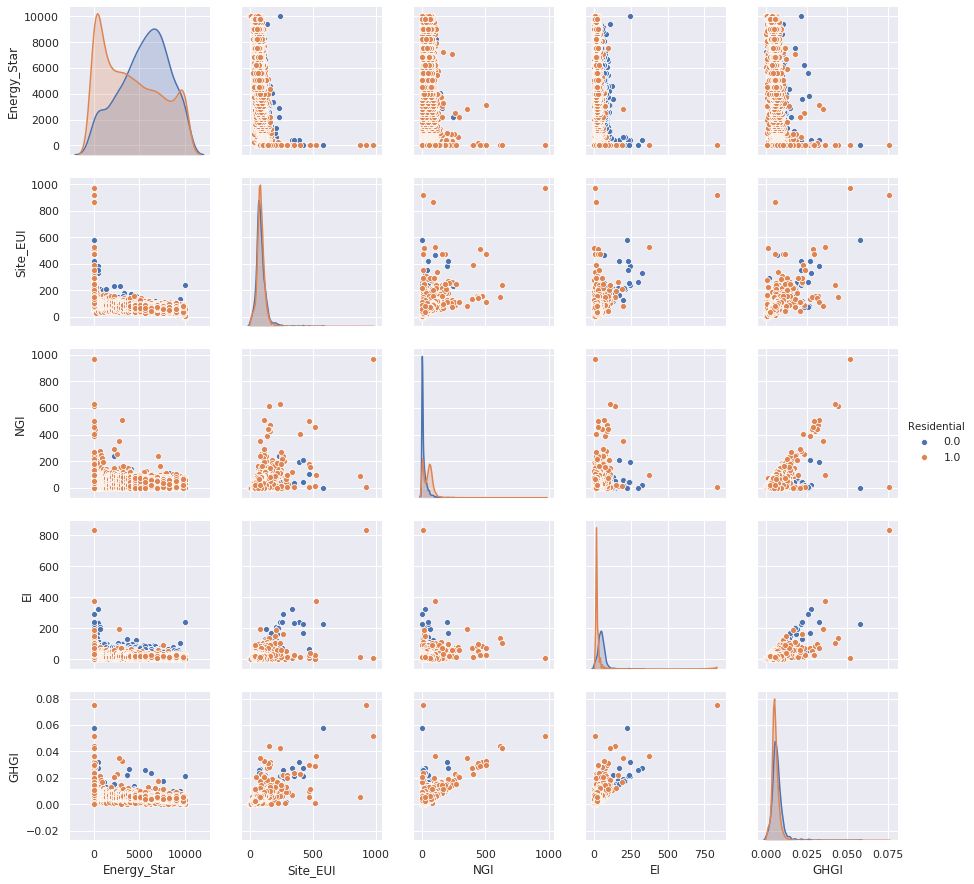

In [109]:
X_fin_df = X_sqrt_df.apply(lambda x: x*x)

sns.pairplot(X_fin_df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             hue='Residential')

In [1]:
pandas_gbq.to_gbq(X_fin_df,"db_gb.data_clean")

--------------
## Next Steps
---------------